<font size=6> Comparative Analysis of ML algorithms on donors-choose dataset

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import pickle
from tqdm import tqdm_notebook as tqdm
import os


## Loading the data

In [4]:
donor = pd.read_csv('Donor Choose/train_data.csv')
donor.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [5]:
resource = pd.read_csv('Donor Choose/resources.csv', ) 
resource.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


## Creating a function to process text

In [6]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [8]:
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

## Preprocessing project title and essay.





In [9]:
# merge two column text dataframe: 
donor["essay"] = donor["project_essay_1"].map(str) +\
                    donor["project_essay_2"].map(str) + \
                        donor["project_essay_3"].map(str) + \
                            donor["project_essay_4"].map(str)

In [10]:
preprocessed_essays = preprocess_text(donor['essay'].values)

In [12]:
donor['essay'] = preprocessed_essays

In [13]:
preprocessed_titles = preprocess_text(donor['project_title'].values)

In [14]:
donor['project_title'] = preprocessed_titles

## Preprocessing teacher_prefix, school_state, project_grade_category, project_subject_categories, project_subject_subcategories




### teacher_prefix

In [15]:
donor['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [16]:
# check if we have any nan values are there
print(donor['teacher_prefix'].isnull().values.any())
print("number of nan values",donor['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


In [17]:
#replacing nan values with Mrs. because it is prominent in the data.
donor['teacher_prefix']=donor['teacher_prefix'].fillna('Mrs.')

In [18]:
donor['teacher_prefix'] = donor['teacher_prefix'].str.replace('.','')
donor['teacher_prefix'] = donor['teacher_prefix'].str.lower()
donor['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

### school_state

In [19]:
# check if we have any nan values are there
print(donor['teacher_prefix'].isnull().values.any())
print("number of nan values",donor['teacher_prefix'].isnull().values.sum())

False
number of nan values 0


In [20]:
donor['school_state'] = donor['school_state'].str.lower()
donor['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

### project_grade_category

In [21]:
donor['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [22]:
donor['project_grade_category'] = donor['project_grade_category'].str.replace(' ','_')
donor['project_grade_category'] = donor['project_grade_category'].str.replace('-','_')
donor['project_grade_category'] = donor['project_grade_category'].str.lower()
donor['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

### project_subject_categories

In [23]:
donor['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [24]:
donor['project_subject_categories'] = donor['project_subject_categories'].str.replace(' The ','')
donor['project_subject_categories'] = donor['project_subject_categories'].str.replace(' ','')
donor['project_subject_categories'] = donor['project_subject_categories'].str.replace('&','_')
donor['project_subject_categories'] = donor['project_subject_categories'].str.replace(',',' ')
donor['project_subject_categories'] = donor['project_subject_categories'].str.lower()
donor['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language specialneeds           3961
appliedlearning                          3771
math_science literacy_language           2289
appliedlearning literacy_language        2191
history_civics                           1851
math_science specialneeds                1840
literacy_language music_arts             1757
math_science music_arts                  1642
appliedlearning specialneeds             1467
history_civics literacy_language         1421
health_sports specialneeds               1391
warmth care_hunger                       1309
math_science appliedlearning             1220
appliedlearning math_science             1052
literacy_language history_civics          809
health_sports literacy_language   

### project_subject_subcategories

In [25]:
donor['project_subject_subcategories'].value_counts()


Literacy                                  9486
Literacy, Mathematics                     8325
Literature & Writing, Mathematics         5923
Literacy, Literature & Writing            5571
Mathematics                               5379
                                          ... 
Civics & Government, Foreign Languages       1
ESL, Economics                               1
Other, Warmth, Care & Hunger                 1
Economics, Music                             1
Extracurricular, Financial Literacy          1
Name: project_subject_subcategories, Length: 401, dtype: int64

In [26]:
donor['project_subject_subcategories'] = donor['project_subject_subcategories'].str.replace(' The ','')
donor['project_subject_subcategories'] = donor['project_subject_subcategories'].str.replace(' ','')
donor['project_subject_subcategories'] = donor['project_subject_subcategories'].str.replace('&','_')
donor['project_subject_subcategories'] = donor['project_subject_subcategories'].str.replace(',',' ')
donor['project_subject_subcategories'] = donor['project_subject_subcategories'].str.lower()
donor['project_subject_subcategories'].value_counts()

literacy                                 9486
literacy mathematics                     8325
literature_writing mathematics           5923
literacy literature_writing              5571
mathematics                              5379
                                         ... 
civics_government foreignlanguages          1
literature_writing nutritioneducation       1
extracurricular financialliteracy           1
history_geography warmth care_hunger        1
financialliteracy foreignlanguages          1
Name: project_subject_subcategories, Length: 401, dtype: int64

## Adding the resource data 

**resource data contains price and quantity of the data, we use grouby and sum the data on the basis of ID of the resource to get the total quantity and amount of the resource.**

In [27]:
price_ = resource.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


## merging and final data

In [28]:
# join two dataframes in python: 
donor = pd.merge(donor, price_, on='id', how='left')
donor.head(10)             #Final data after preprocessing.


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl literacy,educational support english learners home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,students english learners working english seco...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics health_sports,civics_government teamsports,wanted projector hungry learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,students arrive school eager learn polite gene...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness teamsports,soccer equipment awesome middle school students,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,true champions not always ones win guts mia ha...,516.85,22
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,mrs,ky,2016-10-06 21:16:17,grades_prek_2,literacy_language math_science,literacy mathematics,techie kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,work unique school filled esl english second l...,232.90,4
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,mrs,tx,2016-07-11 01:10:09,grades_prek_2,math_science,mathematics,interactive math tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,second grade classroom next year made around 2...,67.98,4
5,141660,p154343,a50a390e8327a95b77b9e495b58b9a6e,mrs,fl,2017-04-08 22:40:43,grades_3_5,literacy_language specialneeds,literature_writing specialneeds,flexible seating mrs jarvis terrific third gra...,I will be moving from 2nd grade to 3rd grade a...,These flexible seating options will allow my s...,NaN,NaN,My students need movement to be successful. Be...,1,1,moving 2nd grade 3rd grade beginning next scho...,113.22,11
6,21147,p099819,9b40170bfa65e399981717ee8731efc3,mrs,ct,2017-02-17 19:58:56,grades_6_8,literacy_language specialneeds,literacy specialneeds,chromebooks special education reading program,My students are a dynamic and very energetic g...,My students are an engaging and active group o...,NaN,NaN,My students need some dependable laptops for d...,1,1,students dynamic energetic group middle school...,159.99,3
7,94142,p092424,5bfd3d12fae3d2fe88684bbac570c9d2,ms,ga,2016-09-01 00:02:15,grades_3_5,math_science,mathematics,21st century,Not only do our students struggle with poverty...,"My students need 4 iPads, the latest technolog...",NaN,NaN,My students need ipads to help them access a w...,7,1,not students struggle poverty also learning ma...,229.00,4
8,112489,p045029,487448f5226005d08d36bdd75f095b31,mrs,sc,2016-09-25 17:00:26,grades_prek_2,health_sports,health_wellness,targeting success class,My students are enthusiastic and inquisitive l...,My second graders need extra activity time dur...,NaN,NaN,My students need three devices and three manag...,28,1,students enthusiastic inquisitive learners k 6...,241.98,6
9,158561,p001713,140eeac1885c820ad5592a409a3a8994,ms,nc,2016-11-17 18:18:56,grades_prek_2,literacy_language,literacy literature_writing,love reading pure pleasure,Over 95% 

## Splitting the data into train and test

In [29]:
X = donor[['teacher_prefix','school_state','project_title','project_grade_category','project_subject_categories','project_subject_subcategories','essay',"teacher_number_of_previously_posted_projects",'price', ]]
X.head()

,teacher_prefix,school_state,project_title,project_grade_category,project_subject_categories,project_subject_subcategories,essay,teacher_number_of_previously_posted_projects,price
0,mrs,in,educational support english learners home,grades_prek_2,literacy_language,esl literacy,students english learners working english seco...,0,154.60
1,mr,fl,wanted projector hungry learners,grades_6_8,history_civics health_sports,civics_government teamsports,students arrive school eager learn polite gene...,7,299.00
2,ms,az,soccer equipment awesome middle school students,grades_6_8,health_sports,health_wellness teamsports,true champions not always ones win guts mia ha...,1,516.85
3,mrs,ky,techie kindergarteners,grades_prek_2,literacy_language math_science,literacy mathematics,work unique school filled esl english second l...,4,232.90
4,mrs,tx,interactive math tools,grades_prek_2,math_science,mathematics,second grade classroom next year made around 2...,1,67.98


In [47]:
Y = donor[['project_is_approved']]
Y.head()


,project_is_approved
0,0
1,1
2,0
3,1
4,1


In [49]:
# train test split
from sklearn.model_selection import train_test_split
x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)


## Converting project title and essay into TFIDF vector.

### Project Essay

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=20)

vectorizer.fit(x_train['essay'].values)

x_train_essay_tfidf = vectorizer.transform(x_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("Shape of x_train_essay_tfidf after one hot encoding", x_train_essay_tfidf.shape)
print("Shape of X_test_essay_tfidf after one hot encoding", X_test_essay_tfidf.shape)

Shape of x_train_essay_tfidf after one hot encoding (73196, 10575)
Shape of X_test_essay_tfidf after one hot encoding (36052, 10575)


### Project Title

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2)

vectorizer.fit(x_train['project_title'].values)

x_train_title_tfidf = vectorizer.transform(x_train['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("Shape of matrix of x_train_title_tfidf after one hot encoding ",x_train_title_tfidf.shape)
print("Shape of matrix of X_test_title_tfidf after one hot encoding", X_test_title_tfidf.shape)

Shape of matrix of x_train_title_tfidf after one hot encoding  (73196, 7449)
Shape of matrix of X_test_title_tfidf after one hot encoding (36052, 7449)


## Applying BoW on the categorical features

### teacher_prefix(applying BoW)

In [52]:
#applying binary BoW on states as only 1 word will be present in whole row.
vectorizer = CountVectorizer()

vectorizer.fit(x_train['teacher_prefix'].values)

x_train_prefix_bow = vectorizer.transform(x_train['teacher_prefix'].values)
X_test_prefix_bow = vectorizer.transform(X_test['teacher_prefix'].values)

print("Shape of x_train_prefix_bow", x_train_prefix_bow.shape)
print("Shape of X_test_prefix_bow", X_test_prefix_bow.shape)

Shape of x_train_prefix_bow (73196, 5)
Shape of X_test_prefix_bow (36052, 5)


### school_state (applying BoW)

In [53]:
#applying binary BoW on states as only 1 word will be present in whole row. 
vectorizer = CountVectorizer()

vectorizer.fit(x_train['school_state'].values)

x_train_state_bow = vectorizer.transform(x_train['school_state'].values)
X_test_state_bow = vectorizer.transform(X_test['school_state'].values)

print("Shape of matrix of x_train_state_bow after one hot encoding ",x_train_state_bow.shape)
print("Shape of matrix of X_test_state_bow after one hot encoding", X_test_state_bow.shape)
type(X_test_state_bow)

Shape of matrix of x_train_state_bow after one hot encoding  (73196, 51)
Shape of matrix of X_test_state_bow after one hot encoding (36052, 51)


scipy.sparse.csr.csr_matrix

### project_grade_category

In [54]:
vectorizer = CountVectorizer()

vectorizer.fit(x_train['project_grade_category'].values)

x_train_grade_bow = vectorizer.transform(x_train['project_grade_category'].values)
X_test_grade_bow = vectorizer.transform(X_test['project_grade_category'].values)

print("Shape of matrix of x_train_grade_bow after one hot encoding", x_train_grade_bow.shape)
print("Shape of matrix of X_test_grade_bow after one hot encoding", X_test_grade_bow.shape)


Shape of matrix of x_train_grade_bow after one hot encoding (73196, 4)
Shape of matrix of X_test_grade_bow after one hot encoding (36052, 4)


### project_subject_categories

In [55]:
vectorizer = CountVectorizer()

vectorizer.fit(x_train['project_subject_categories'].values)

x_train_cat_bow = vectorizer.transform(x_train['project_subject_categories'].values)
X_test_cat_bow = vectorizer.transform(X_test['project_subject_categories'].values)

print("Shape of matrix of x_train_cat_bow after one hot encoding", x_train_cat_bow.shape)
print("Shape of matrix of X_test_cat_bow after one hot encoding", X_test_cat_bow.shape)


Shape of matrix of x_train_cat_bow after one hot encoding (73196, 9)
Shape of matrix of X_test_cat_bow after one hot encoding (36052, 9)


### project_subject_subcategories

In [56]:
vectorizer = CountVectorizer()

vectorizer.fit(x_train['project_subject_subcategories'].values)

x_train_subcat_bow = vectorizer.transform(x_train['project_subject_subcategories'].values)
X_test_subcat_bow = vectorizer.transform(X_test['project_subject_subcategories'].values)

print("Shape of matrix of x_train_subcat_bow after one hot encoding", x_train_subcat_bow.shape)
print("Shape of matrix of X_test_subcat_bow after one hot encoding", X_test_subcat_bow.shape)

Shape of matrix of x_train_subcat_bow after one hot encoding (73196, 30)
Shape of matrix of X_test_subcat_bow after one hot encoding (36052, 30)


### teacher_number_of_previoulsy_posted_projects

In [57]:
x_train_pnum = (x_train['teacher_number_of_previously_posted_projects'].values).reshape(-1,1)

X_test_pnum = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print("Shape of matrix of x_train_pnum", x_train_pnum.shape)
print("Shape of matrix of X_test_pnum", X_test_pnum.shape)


Shape of matrix of x_train_pnum (73196, 1)
Shape of matrix of X_test_pnum (36052, 1)


### Price

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(x_train['price'].values.reshape(-1,1))

x_train_price = normalizer.transform(x_train['price'].values.reshape(-1,1))
X_test_price = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("Shape of matrix of x_train_price after normalization", x_train_price.shape)
print("Shape of matrix of X_test_price after normalization", X_test_price.shape)

Shape of matrix of x_train_price after normalization (73196, 1)
Shape of matrix of X_test_price after normalization (36052, 1)


## Stacking the arrays and getting final dataset for train,test

In [70]:
from scipy.sparse import hstack

Fx_train = hstack((x_train_prefix_bow, x_train_state_bow, x_train_title_tfidf, x_train_grade_bow, x_train_pnum, x_train_cat_bow, x_train_subcat_bow, x_train_essay_tfidf, x_train_price))


FX_test = hstack((X_test_prefix_bow, X_test_state_bow, X_test_title_tfidf, X_test_grade_bow, X_test_pnum, X_test_cat_bow, X_test_subcat_bow, X_test_essay_tfidf, X_test_price))

Fy_train = y_train.to_numpy()                             #y_train.to_numpy has output of only values
FY_test = Y_test.to_numpy()

print("Final shape of Fx_train matrix", Fx_train.shape)        
print("Final shape of FX_test matrix", FX_test.shape)
print("Final shape of Fy_train",Fy_train.shape)                     
print("Final shape of FY_test", FY_test.shape)
type(Fx_train)

Final shape of Fx_train matrix (73196, 18125)
Final shape of FX_test matrix (36052, 18125)
Final shape of Fy_train (73196, 1)
Final shape of FY_test (36052, 1)


scipy.sparse.coo.coo_matrix

## Applying the Decision tree classifier 

In [60]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV


parameter = {'max_depth':[1,5,10,50], 'min_samples_split':[5,10,100,500]}
dt = tree.DecisionTreeClassifier(class_weight='balanced')


grid_dt = GridSearchCV(estimator= dt, param_grid=parameter, scoring='accuracy', cv=5,)

In [61]:
grid_dt.fit(Fx_train, Fy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [65]:
grid_dt.best_score_

0.7520356833699336

In [66]:
grid_dt.best_params_

{'max_depth': 1, 'min_samples_split': 5}

In [68]:
clf = tree.DecisionTreeClassifier(max_depth= 1, min_samples_split=5, class_weight='balanced')

In [69]:
clf.fit(Fx_train, Fy_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [71]:
ypred = clf.predict(FX_test)

In [79]:
print('Accuracy in Decision tree classifier ',accuracy_score(FY_test, ypred)*100,'%')

Accuracy in Decision tree classifier  74.49517363807833 %


# Applying Naive Bayes Classifier

In [82]:
from sklearn.naive_bayes import MultinomialNB

parameter_nb = {'alpha': [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.9]}
nb = MultinomialNB()

grid_nb = GridSearchCV(estimator=nb, param_grid=parameter_nb, scoring='accuracy', cv=5)

In [83]:
grid_nb.fit(Fx_train, Fy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3,
                                   0.5, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [84]:
grid_nb.best_score_

0.6089678154058867

In [86]:
grid_nb.best_params_

{'alpha': 0.001}

In [87]:
clf = MultinomialNB(alpha=0.01)

In [88]:
clf.fit(Fx_train, Fy_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [89]:
ypred_nb = clf.predict(FX_test)

In [114]:
print('Accuracy in Naive Bayes classifier ',accuracy_score(FY_test, ypred_nb)*100,'%')

Accuracy in Naive Bayes classifier  59.13957616775768 %


# Applying Random Forest Classifier

In [93]:
from sklearn.ensemble import RandomForestClassifier

parameter_rf = {'n_estimators':[10,50,100,200], 'max_depth':[1,2,5,]}

rf = RandomForestClassifier()

grid_rf = GridSearchCV(estimator=rf, param_grid=parameter_rf,scoring='accuracy', cv=5)

In [94]:
grid_rf.fit(Fx_train, Fy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [95]:
grid_rf.best_score_

0.8485846223707387

In [96]:
grid_rf.best_params_

{'max_depth': 1, 'n_estimators': 10}

In [97]:
clf = RandomForestClassifier(max_depth= 1, n_estimators=10)

In [98]:
clf.fit(Fx_train, Fy_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
ypred_rf = clf.predict(FX_test)

In [113]:
print('Accuracy in Random Forest classifier ',accuracy_score(FY_test, ypred_rf)*100,'%')

Accuracy in Random Forest classifier  84.85798291356929 %


# Applying K-Nearest Neighbours 

In [104]:
from sklearn.neighbors import KNeighborsClassifier

parameter_knn = {'n_neighbors':[3,5,7]}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(estimator=knn, param_grid=parameter_knn, scoring='accuracy',cv=5)

In [105]:
grid_knn.fit(Fx_train, Fy_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)

In [106]:
grid_knn.best_score_

0.8383654626816532

In [107]:
grid_knn.best_params_

{'n_neighbors': 7}

In [109]:
clf = KNeighborsClassifier(n_neighbors=9)

In [110]:
clf.fit(Fx_train, Fy_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [111]:
ypred_knn = clf.predict(FX_test)

In [112]:
print('Accuracy in K Nearest Neighbour Classifier ',accuracy_score(FY_test, ypred_knn)*100,'%')

Accuracy in K Nearest Neighbour Classifier  84.34760900920892 %


# Comparison

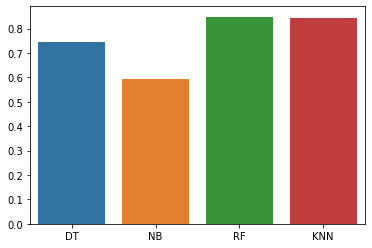

In [125]:
import seaborn as sns

x = ['DT', 'NB', 'RF', 'KNN']
y = [accuracy_score(FY_test,ypred), accuracy_score(FY_test,ypred_nb), 
     accuracy_score(FY_test,ypred_rf), accuracy_score(FY_test,ypred_knn)]

sns.barplot(x,y, )

## Random Forest and Naive Bayes performs almost same getting 85% accuracy